In [1]:
%pylab inline
import galsim
import fpfs
import impt
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


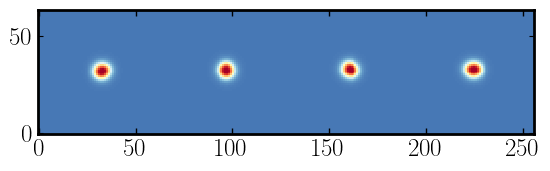

In [2]:
shear_value = 0.02
scale = 0.168
ngrid = 64

psf_obj = galsim.Moffat(
    beta=3.5, fwhm=0.6, trunc=0.6 * 4.0
).shear(e1=0.02, e2=-0.02)

psfData = psf_obj.shift(
    0.5 * scale, 
    0.5 * scale
).drawImage(nx=ngrid, ny=ngrid, scale=scale).array
ud = galsim.UniformDeviate(1)
# use galaxies with random knots
# we only support three versions of small galaxies with different radius

nx, ny =ngrid*4, ngrid
ngalx = int(nx // ngrid)
ngaly = int(ny // ngrid)
ngal = ngalx * ngaly
# Get the shear information
g1 = shear_value
g2 = 0.0
gal_image = galsim.ImageF(nx, ny, scale=scale)
gal_image.setOrigin(0, 0)
bigfft = galsim.GSParams(maximum_fft_size=10240)


radius = 0.20
npoints = 10
gal0 = galsim.RandomKnots(
    half_light_radius=radius, npoints=npoints, flux=10.0, rng=ud
)
for ix in range(4):
    for iy in range(1):
        igal = ix
        b = galsim.BoundsI(
            ix * ngrid, (ix + 1) * ngrid - 1, iy * ngrid, (iy + 1) * ngrid - 1
        )
        if igal == 0:
            gal0 = galsim.RandomKnots(
                half_light_radius=radius,
                npoints=npoints,
                flux=10.0,
                rng=ud,
                gsparams=bigfft,
            )
        sub_img = gal_image[b]
        ang = igal * np.pi / 4.0 * galsim.radians
        gal = gal0.rotate(ang)
        # Shear the galaxy
        gal = gal.shear(g1=g1, g2=g2)
        gal = galsim.Convolve([psf_obj, gal], gsparams=bigfft)
        gal = gal.shift(0.5 * scale, 0.5 * scale)
        # Draw the galaxy image
        gal.drawImage(sub_img, add_to_image=True)
        del gal, b, sub_img
del ud

gal_data = gal_image.array


plt.close()
plt.imshow(gal_data,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(gal_data,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.3))
plt.show()

In [3]:
# Now we measure shear
rcut = 32
# Force detection
indX = np.arange(int(ngrid/2), nx, ngrid)
indY = np.arange(int(ngrid/2), ny, ngrid)
inds = np.meshgrid(indY, indX, indexing="ij")
coords = np.vstack(inds).T

fpTask  =   fpfs.image.measure_source(psfData,pix_scale = scale, sigma_arcsec=0.6)
mms =  fpTask.measure(gal_data, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp

print('Input shear is: %.6f' %shear_value)
print('Estimated shear is: %.6f' %shear)

2023/08/15 14:15:50 ---  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023/08/15 14:15:50 ---  Order of the shear estimator: nnord=4
2023/08/15 14:15:50 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/08/15 14:15:50 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


Input shear is: 0.020000
Estimated shear is: 0.019994
